In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from lifelines.utils import concordance_index

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

from sklearn.cluster import KMeans
from sklearn.metrics import (adjusted_rand_score, normalized_mutual_info_score, confusion_matrix,
                              accuracy_score, f1_score, precision_score, recall_score, roc_auc_score,
                              silhouette_score, calinski_harabasz_score, davies_bouldin_score)
from sklearn.preprocessing import StandardScaler, LabelEncoder, label_binarize
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.feature_selection import VarianceThreshold
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB

from torch_geometric.nn import GATConv, GCNConv
from torch_geometric.data import Data
from torch_geometric.nn import knn_graph


torch.manual_seed(42)
np.random.seed(42)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
print(f'Importing Data_preprocess_3Omics processed datasets for direct fusion analysis')
print("=" * 80)

# Load the preprocessed datasets from Data_preprocess_3Omics pipeline
print("🔄 Loading preprocessed datasets...")
expression_scaled2 = pd.read_csv("../NewDatasets/processed_expression_FXS_OG.csv", index_col=0)
methylation_scaled2 = pd.read_csv("../NewDatasets/processed_methylation_FXS_OG.csv", index_col=0)
copy_number_scaled2 = pd.read_csv("../NewDatasets/processed_cnv_FXS_OG.csv", index_col=0)
phenotype_data_clean2 = pd.read_csv("../NewDatasets/processed_phenotype_FXS_OG.csv", index_col=0)
labels = pd.read_csv("../NewDatasets/processed_labels_3Omics_FXS_OG.csv", index_col=0)

print("📊 Original Dataset Shapes (Features x Samples):")
print(f"   Expression: {expression_scaled2.shape} (genes x samples)")
print(f"   Methylation: {methylation_scaled2.shape} (CpG sites x samples)")
print(f"   Copy Number: {copy_number_scaled2.shape} (regions x samples)")
print(f"   Phenotype: {phenotype_data_clean2.shape} (samples x features)")
print(f"   Labels: {labels.shape} (samples)")

# Transpose omics data to have samples as rows (required for ML models)
print("\n🔄 Transposing omics data (samples as rows)...")
expression_scaled2 = expression_scaled2.T  # Now (samples x genes)
methylation_scaled2 = methylation_scaled2.T  # Now (samples x CpG sites)
copy_number_scaled2 = copy_number_scaled2.T  # Now (samples x regions)

expression_scaled2 = pd.DataFrame(
    StandardScaler().fit_transform(expression_scaled2),
    index=expression_scaled2.index,
    columns=expression_scaled2.columns
)

methylation_scaled2 = pd.DataFrame(
    StandardScaler().fit_transform(methylation_scaled2),
    index=methylation_scaled2.index,
    columns=methylation_scaled2.columns
)

copy_number_scaled2 = pd.DataFrame(
    StandardScaler().fit_transform(copy_number_scaled2),
    index=copy_number_scaled2.index,
    columns=copy_number_scaled2.columns
)

print("\n✅ Omics data standardized (samples as rows, features scaled column-wise).")
# print("Expression data (final scaled shape):", expression_scaled_final.shape)

print("📊 After transpose (Samples x Features):")
print(f"   Expression: {expression_scaled2.shape} (samples x genes)")
print(f"   Methylation: {methylation_scaled2.shape} (samples x CpG sites)")
print(f"   Copy Number: {copy_number_scaled2.shape} (samples x regions)")

# Verify data quality (should have no missing values from preprocessing)
print("\n🔍 Data Quality Check:")
print(f"   Expression missing values: {expression_scaled2.isnull().sum().sum()}")
print(f"   Methylation missing values: {methylation_scaled2.isnull().sum().sum()}")
print(f"   Copy Number missing values: {copy_number_scaled2.isnull().sum().sum()}")
print(f"   Labels missing values: {labels.isnull().sum().sum()}")

# Check sample alignment (should be perfect from preprocessing)
common_samples_check = [
    set(expression_scaled2.index),
    set(methylation_scaled2.index), 
    set(copy_number_scaled2.index),
    set(labels.index)
]

all_aligned = all(s == common_samples_check[0] for s in common_samples_check)
print(f"\n✅ Sample alignment: {'Perfect' if all_aligned else 'Misaligned'}")
print(f"📊 Total samples: {len(expression_scaled2)}")


Importing Data_preprocess_3Omics processed datasets for direct fusion analysis
🔄 Loading preprocessed datasets...
📊 Original Dataset Shapes (Features x Samples):
   Expression: (44663, 205) (genes x samples)
   Methylation: (419542, 205) (CpG sites x samples)
   Copy Number: (56756, 205) (regions x samples)
   Phenotype: (205, 78) (samples x features)
   Labels: (205, 1) (samples)

🔄 Transposing omics data (samples as rows)...
📊 Original Dataset Shapes (Features x Samples):
   Expression: (44663, 205) (genes x samples)
   Methylation: (419542, 205) (CpG sites x samples)
   Copy Number: (56756, 205) (regions x samples)
   Phenotype: (205, 78) (samples x features)
   Labels: (205, 1) (samples)

🔄 Transposing omics data (samples as rows)...

✅ Omics data standardized (samples as rows, features scaled column-wise).
📊 After transpose (Samples x Features):
   Expression: (205, 44663) (samples x genes)
   Methylation: (205, 419542) (samples x CpG sites)
   Copy Number: (205, 56756) (samples x

In [3]:
# Apply PCA to Individual Omics First, Then Create Fusion
print("Applying PCA to Individual Omics, Then Creating Fusion...")
print("=" * 80)

# PCA components for each omic type
pca_components = {
    'expression': 50,
    'methylation': 120, 
    'cnv': 60
}

pca_expression = PCA(n_components=pca_components['expression'], random_state=42)
expression_pca = pd.DataFrame(
    pca_expression.fit_transform(expression_scaled2),
    index=expression_scaled2.index,
    columns=[f'Expr_PC{i+1}' for i in range(pca_components['expression'])]
)

pca_methylation = PCA(n_components=pca_components['methylation'], random_state=42)
methylation_pca = pd.DataFrame(
    pca_methylation.fit_transform(methylation_scaled2),
    index=methylation_scaled2.index,
    columns=[f'Meth_PC{i+1}' for i in range(pca_components['methylation'])]
)

pca_cnv = PCA(n_components=pca_components['cnv'], random_state=42)
cnv_pca = pd.DataFrame(
    pca_cnv.fit_transform(copy_number_scaled2),
    index=copy_number_scaled2.index,
    columns=[f'CNV_PC{i+1}' for i in range(pca_components['cnv'])]
)

print(f"\n🔗 Creating Fusion from Individual PCA Results...")
fpca_individual_fusion = pd.concat([
    expression_pca,
    methylation_pca, 
    cnv_pca
], axis=1)

# Verify no missing values
print(f"\n🔍 Data Quality Check:")
print(f"   Individual PCA fusion missing values: {fpca_individual_fusion.isnull().sum().sum()}")

Applying PCA to Individual Omics, Then Creating Fusion...

🔗 Creating Fusion from Individual PCA Results...

🔍 Data Quality Check:
   Individual PCA fusion missing values: 0

🔗 Creating Fusion from Individual PCA Results...

🔍 Data Quality Check:
   Individual PCA fusion missing values: 0


# Autoencoder-Based Analysis Pipeline

This section implements autoencoder-based dimensionality reduction followed by machine learning classification.

In [4]:
# Autoencoder Class and Training Function
print("AUTOENCODER ARCHITECTURE DEFINITION")
print("=" * 80)

class Autoencoder(nn.Module):
    def __init__(self, input_dim, latent_dim=64, dropout=0.3):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(256, latent_dim)
        )
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 256),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(256, input_dim)
        )
    
    def forward(self, x):
        z = self.encoder(x)
        x_recon = self.decoder(z)
        return x_recon, z

class ShallowAutoencoder(nn.Module):
    def __init__(self, input_dim, latent_dim=64, dropout=0.3):
        super(ShallowAutoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, latent_dim),
            nn.ReLU(),
            nn.Dropout(dropout)
        )
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, input_dim),
            nn.ReLU(),
            nn.Dropout(dropout)
        )
    
    def forward(self, x):
        z = self.encoder(x)
        x_recon = self.decoder(z)
        return x_recon, z

def train_autoencoder(model, data, device, epochs=400, lr=1e-3, patience=20):
    # Split data for training and validation
    data_np = data.cpu().numpy() if torch.is_tensor(data) else data
    X_train, X_val = train_test_split(data_np, test_size=0.2, random_state=42)
    
    X_train_tensor = torch.FloatTensor(X_train).to(device)
    X_val_tensor = torch.FloatTensor(X_val).to(device)
    
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=1e-4)
    criterion = nn.MSELoss()
    
    train_losses = []
    val_losses = []
    best_val_loss = np.inf
    best_model_state = None
    patience_counter = 0
    
    for epoch in range(epochs):
        # Training
        model.train()
        optimizer.zero_grad()
        x_recon, _ = model(X_train_tensor)
        train_loss = criterion(x_recon, X_train_tensor)
        train_loss.backward()
        optimizer.step()
        
        # Validation
        model.eval()
        with torch.no_grad():
            val_recon, _ = model(X_val_tensor)
            val_loss = criterion(val_recon, X_val_tensor)
        
        train_losses.append(train_loss.item())
        val_losses.append(val_loss.item())
        
        # Early stopping check
        if val_loss.item() < best_val_loss:
            best_val_loss = val_loss.item()
            best_model_state = model.state_dict()
            patience_counter = 0
        else:
            patience_counter += 1
            
        if patience_counter >= patience:
            print(f"   Early stopping at epoch {epoch+1}")
            break
    
    # Restore best model
    if best_model_state:
        model.load_state_dict(best_model_state)
    
    return model, {'train_losses': train_losses, 'val_losses': val_losses}

print("✅ Autoencoder classes and training function defined!")
print(f"   Deep Architecture: Input → 256 → Latent → 256 → Output (2 layers)")
print(f"   Shallow Architecture: Input → Latent → Output (1 layer)")
print(f"   Features: Dropout regularization, early stopping, MSE loss")

AUTOENCODER ARCHITECTURE DEFINITION
✅ Autoencoder classes and training function defined!
   Deep Architecture: Input → 256 → Latent → 256 → Output (2 layers)
   Shallow Architecture: Input → Latent → Output (1 layer)
   Features: Dropout regularization, early stopping, MSE loss


In [5]:
# ML Models Evaluation Function
print("MACHINE LEARNING MODELS DEFINITION")
print("=" * 80)

def evaluate_ml_models_on_embeddings(embeddings, labels, k_folds=5):
    """
    Evaluate multiple ML classifiers on autoencoder embeddings
    
    Args:
        embeddings: Latent representations from autoencoder
        labels: Target labels
        k_folds: Number of cross-validation folds
        
    Returns:
        Dictionary with comprehensive metrics for each model
    """
    models = {
        'RandomForest': RandomForestClassifier(n_estimators=100, random_state=42, max_depth=10),
        'GradientBoosting': GradientBoostingClassifier(n_estimators=100, random_state=42, max_depth=5),
        'LogisticRegression': LogisticRegression(max_iter=1000, random_state=42, multi_class='ovr'),
        'SVM_RBF': SVC(kernel='rbf', random_state=42, probability=True),
        'KNN': KNeighborsClassifier(n_neighbors=4),
        'NaiveBayes': GaussianNB()
    }
    
    results = {}
    skf = StratifiedKFold(n_splits=k_folds, shuffle=True, random_state=42)
    
    # Split data into train and test sets for proper evaluation
    X_train, X_test, y_train, y_test = train_test_split(
        embeddings, labels, test_size=0.2, random_state=42, stratify=labels
    )
    
    for model_name, model in models.items():
        print(f"\n⚙️  Training {model_name}...")
        
        # Cross-validation scores (on full data for comparison)
        cv_scores = cross_val_score(model, embeddings, labels, cv=skf, scoring='accuracy')
        
        # Train on train set and evaluate on test set (PROPER EVALUATION)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        y_pred_proba = model.predict_proba(X_test)
        
        # Calculate comprehensive metrics on TEST SET
        accuracy = accuracy_score(y_test, y_pred)
        f1_macro = f1_score(y_test, y_pred, average='macro')
        f1_micro = f1_score(y_test, y_pred, average='micro')
        precision = precision_score(y_test, y_pred, average='macro')
        recall = recall_score(y_test, y_pred, average='macro')
        
        # AUC (one-vs-rest for multiclass)
        try:
            n_classes = len(np.unique(y_test))
            if n_classes == 2:
                auc = roc_auc_score(y_test, y_pred_proba[:, 1])
            else:
                y_test_bin = label_binarize(y_test, classes=np.unique(y_test))
                auc = roc_auc_score(y_test_bin, y_pred_proba, average='macro', multi_class='ovr')
        except:
            auc = None
        
        # C-index (concordance index)
        try:
            c_index = concordance_index(y_test, y_pred_proba.max(axis=1))
        except:
            c_index = None
        
        # Confusion matrix
        cm = confusion_matrix(y_test, y_pred)
        
        results[model_name] = {
            'accuracy': accuracy,
            'f1_macro': f1_macro,
            'f1_micro': f1_micro,
            'precision': precision,
            'recall': recall,
            'auc': auc,
            'c_index': c_index,
            'cv_scores': cv_scores,
            'cv_mean': cv_scores.mean(),
            'cv_std': cv_scores.std(),
            'confusion_matrix': cm
        }
        
        print(f"   ✅ {model_name}: Accuracy={accuracy:.4f}, F1_macro={f1_macro:.4f}, F1_micro={f1_micro:.4f}")
    
    return results

print("✅ ML evaluation function defined!")
print(f"   Models: RandomForest, GradientBoosting, LogisticRegression, SVM, KNN, NaiveBayes")
print(f"   Metrics: accuracy, f1_macro, f1_micro, precision, recall, AUC, c-index, CV scores")

MACHINE LEARNING MODELS DEFINITION
✅ ML evaluation function defined!
   Models: RandomForest, GradientBoosting, LogisticRegression, SVM, KNN, NaiveBayes
   Metrics: accuracy, f1_macro, f1_micro, precision, recall, AUC, c-index, CV scores


In [6]:
# Execute Autoencoder Pipeline and Store Results
print("AUTOENCODER PIPELINE EXECUTION")
print("=" * 80)

# Initialize results dictionaries
ae_scores = {}  # Deep autoencoder results
shallow_ae_scores = {}  # Shallow autoencoder results
ae_embeddings = {}  # Store embeddings for visualization
shallow_ae_embeddings = {}  # Store shallow embeddings for visualization

# Latent dimensions to test
latent_dims = [64, 128]

# Device setup
print(f"🖥️  Using device: {device}\n")

# Use the single fusion data
fusion_data = fpca_individual_fusion.values
print(f"🔬 Processing Individual PCA Fusion: {fusion_data.shape}")
print("=" * 80)

# Prepare data once
X = fusion_data
y = labels.values.ravel()

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_tensor = torch.FloatTensor(X_scaled).to(device)

for latent_dim in latent_dims:
    print(f"\n📊 Latent Dimension: {latent_dim}")
    print("=" * 80)
    
    # ============================================================================
    # DEEP AUTOENCODER
    # ============================================================================
    print(f"🧠 Training Deep Autoencoder (latent_dim={latent_dim})...")
    ae_model = Autoencoder(input_dim=X_scaled.shape[1], latent_dim=latent_dim).to(device)
    ae_model, history = train_autoencoder(ae_model, X_tensor, device)
    
    # Extract deep autoencoder latent embeddings
    ae_model.eval()
    with torch.no_grad():
        _, embeddings_deep = ae_model(X_tensor)
        embeddings_deep_np = embeddings_deep.cpu().numpy()
    
    print(f"   ✅ Deep AE Embeddings shape: {embeddings_deep_np.shape}")
    
    # Evaluate ML models on deep autoencoder embeddings
    print(f"\n🤖 Evaluating ML Models on Deep AE Embeddings...")
    ml_results_deep = evaluate_ml_models_on_embeddings(embeddings_deep_np, y, k_folds=5)
    
    # Calculate clustering metrics for deep autoencoder
    print(f"\n📈 Computing Deep AE Clustering Metrics...")
    n_clusters = len(np.unique(y))
    kmeans_deep = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
    cluster_labels_deep = kmeans_deep.fit_predict(embeddings_deep_np)
    
    ari_deep = adjusted_rand_score(y, cluster_labels_deep)
    nmi_deep = normalized_mutual_info_score(y, cluster_labels_deep)
    silhouette_deep = silhouette_score(embeddings_deep_np, cluster_labels_deep)
    calinski_deep = calinski_harabasz_score(embeddings_deep_np, cluster_labels_deep)
    davies_deep = davies_bouldin_score(embeddings_deep_np, cluster_labels_deep)
    
    print(f"   Deep AE - ARI: {ari_deep:.4f} | NMI: {nmi_deep:.4f} | Silhouette: {silhouette_deep:.4f}")
    print(f"   Deep AE - Calinski-Harabasz: {calinski_deep:.2f} | Davies-Bouldin: {davies_deep:.4f}")
    
    # Deep autoencoder reconstruction error
    ae_model.eval()
    with torch.no_grad():
        recon_deep, _ = ae_model(X_tensor)
        recon_error_deep = nn.MSELoss()(recon_deep, X_tensor).item()
    
    # Store deep autoencoder results
    ae_scores[latent_dim] = {
        'latent_dim': latent_dim,
        'ml_models': ml_results_deep,
        'ari': ari_deep,
        'nmi': nmi_deep,
        'silhouette': silhouette_deep,
        'calinski_harabasz': calinski_deep,
        'davies_bouldin': davies_deep,
        'reconstruction_error': recon_error_deep,
        'embeddings_shape': embeddings_deep_np.shape,
        'train_history': history
    }
    
    # Store deep autoencoder embeddings for visualization
    ae_embeddings[latent_dim] = embeddings_deep_np
    
    print(f"\n✅ Deep AE results saved for latent dimension {latent_dim}")
    
    # ============================================================================
    # SHALLOW AUTOENCODER
    # ============================================================================
    print(f"\n🧠 Training Shallow Autoencoder (latent_dim={latent_dim})...")
    shallow_ae_model = ShallowAutoencoder(input_dim=X_scaled.shape[1], latent_dim=latent_dim).to(device)
    shallow_ae_model, shallow_history = train_autoencoder(shallow_ae_model, X_tensor, device)
    
    # Extract shallow autoencoder latent embeddings
    shallow_ae_model.eval()
    with torch.no_grad():
        _, embeddings_shallow = shallow_ae_model(X_tensor)
        embeddings_shallow_np = embeddings_shallow.cpu().numpy()
    
    print(f"   ✅ Shallow AE Embeddings shape: {embeddings_shallow_np.shape}")
    
    # Evaluate ML models on shallow autoencoder embeddings
    print(f"\n🤖 Evaluating ML Models on Shallow AE Embeddings...")
    ml_results_shallow = evaluate_ml_models_on_embeddings(embeddings_shallow_np, y, k_folds=5)
    
    # Calculate clustering metrics for shallow autoencoder
    print(f"\n📈 Computing Shallow AE Clustering Metrics...")
    kmeans_shallow = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
    cluster_labels_shallow = kmeans_shallow.fit_predict(embeddings_shallow_np)
    
    ari_shallow = adjusted_rand_score(y, cluster_labels_shallow)
    nmi_shallow = normalized_mutual_info_score(y, cluster_labels_shallow)
    silhouette_shallow = silhouette_score(embeddings_shallow_np, cluster_labels_shallow)
    calinski_shallow = calinski_harabasz_score(embeddings_shallow_np, cluster_labels_shallow)
    davies_shallow = davies_bouldin_score(embeddings_shallow_np, cluster_labels_shallow)
    
    print(f"   Shallow AE - ARI: {ari_shallow:.4f} | NMI: {nmi_shallow:.4f} | Silhouette: {silhouette_shallow:.4f}")
    print(f"   Shallow AE - Calinski-Harabasz: {calinski_shallow:.2f} | Davies-Bouldin: {davies_shallow:.4f}")
    
    # Shallow autoencoder reconstruction error
    shallow_ae_model.eval()
    with torch.no_grad():
        recon_shallow, _ = shallow_ae_model(X_tensor)
        recon_error_shallow = nn.MSELoss()(recon_shallow, X_tensor).item()
    
    # Store shallow autoencoder results
    shallow_ae_scores[latent_dim] = {
        'latent_dim': latent_dim,
        'ml_models': ml_results_shallow,
        'ari': ari_shallow,
        'nmi': nmi_shallow,
        'silhouette': silhouette_shallow,
        'calinski_harabasz': calinski_shallow,
        'davies_bouldin': davies_shallow,
        'reconstruction_error': recon_error_shallow,
        'embeddings_shape': embeddings_shallow_np.shape,
        'train_history': shallow_history
    }
    
    # Store shallow autoencoder embeddings for visualization
    shallow_ae_embeddings[latent_dim] = embeddings_shallow_np
    
    print(f"\n✅ Shallow AE results saved for latent dimension {latent_dim}")

print(f"\n{'='*80}")
print(f"🎉 AUTOENCODER PIPELINES COMPLETED!")
print(f"{'='*80}")
print(f"Deep AE latent dimensions evaluated: {list(ae_scores.keys())}")
print(f"Shallow AE latent dimensions evaluated: {list(shallow_ae_scores.keys())}")
print(f"Results stored in 'ae_scores' and 'shallow_ae_scores' dictionaries")

AUTOENCODER PIPELINE EXECUTION
🖥️  Using device: cuda

🔬 Processing Individual PCA Fusion: (205, 230)

📊 Latent Dimension: 64
🧠 Training Deep Autoencoder (latent_dim=64)...
   Early stopping at epoch 187
   ✅ Deep AE Embeddings shape: (205, 64)

🤖 Evaluating ML Models on Deep AE Embeddings...

⚙️  Training RandomForest...
   Early stopping at epoch 187
   ✅ Deep AE Embeddings shape: (205, 64)

🤖 Evaluating ML Models on Deep AE Embeddings...

⚙️  Training RandomForest...


f:\BRACU\Thesis Thingy[T2510589]\DATASET 2\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


   ✅ RandomForest: Accuracy=0.5854, F1_macro=0.3431, F1_micro=0.5854

⚙️  Training GradientBoosting...
   ✅ GradientBoosting: Accuracy=0.5366, F1_macro=0.3819, F1_micro=0.5366

⚙️  Training LogisticRegression...
   ✅ LogisticRegression: Accuracy=0.7073, F1_macro=0.5927, F1_micro=0.7073

⚙️  Training SVM_RBF...
   ✅ GradientBoosting: Accuracy=0.5366, F1_macro=0.3819, F1_micro=0.5366

⚙️  Training LogisticRegression...
   ✅ LogisticRegression: Accuracy=0.7073, F1_macro=0.5927, F1_micro=0.7073

⚙️  Training SVM_RBF...


f:\BRACU\Thesis Thingy[T2510589]\DATASET 2\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:1281: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(
f:\BRACU\Thesis Thingy[T2510589]\DATASET 2\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:1281: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(
f:\BRACU\Thesis Thingy[T2510589]\DATASET 2\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:1281: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(
f:\BRACU\Thesis Thingy[T2510589]\DATA

   ✅ SVM_RBF: Accuracy=0.6098, F1_macro=0.3573, F1_micro=0.6098

⚙️  Training KNN...
   ✅ KNN: Accuracy=0.6341, F1_macro=0.4878, F1_micro=0.6341

⚙️  Training NaiveBayes...
   ✅ NaiveBayes: Accuracy=0.4634, F1_macro=0.3654, F1_micro=0.4634

📈 Computing Deep AE Clustering Metrics...
   Deep AE - ARI: 0.0063 | NMI: 0.0281 | Silhouette: 0.0519
   Deep AE - Calinski-Harabasz: 5.70 | Davies-Bouldin: 4.4183

✅ Deep AE results saved for latent dimension 64

🧠 Training Shallow Autoencoder (latent_dim=64)...
   ✅ KNN: Accuracy=0.6341, F1_macro=0.4878, F1_micro=0.6341

⚙️  Training NaiveBayes...
   ✅ NaiveBayes: Accuracy=0.4634, F1_macro=0.3654, F1_micro=0.4634

📈 Computing Deep AE Clustering Metrics...
   Deep AE - ARI: 0.0063 | NMI: 0.0281 | Silhouette: 0.0519
   Deep AE - Calinski-Harabasz: 5.70 | Davies-Bouldin: 4.4183

✅ Deep AE results saved for latent dimension 64

🧠 Training Shallow Autoencoder (latent_dim=64)...
   Early stopping at epoch 259
   ✅ Shallow AE Embeddings shape: (205, 64)


f:\BRACU\Thesis Thingy[T2510589]\DATASET 2\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


   ✅ RandomForest: Accuracy=0.5122, F1_macro=0.2636, F1_micro=0.5122

⚙️  Training GradientBoosting...
   ✅ GradientBoosting: Accuracy=0.4634, F1_macro=0.3252, F1_micro=0.4634

⚙️  Training LogisticRegression...
   ✅ LogisticRegression: Accuracy=0.5366, F1_macro=0.4425, F1_micro=0.5366

⚙️  Training SVM_RBF...
   ✅ SVM_RBF: Accuracy=0.5854, F1_macro=0.3365, F1_micro=0.5854

⚙️  Training KNN...
   ✅ GradientBoosting: Accuracy=0.4634, F1_macro=0.3252, F1_micro=0.4634

⚙️  Training LogisticRegression...
   ✅ LogisticRegression: Accuracy=0.5366, F1_macro=0.4425, F1_micro=0.5366

⚙️  Training SVM_RBF...
   ✅ SVM_RBF: Accuracy=0.5854, F1_macro=0.3365, F1_micro=0.5854

⚙️  Training KNN...


f:\BRACU\Thesis Thingy[T2510589]\DATASET 2\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:1281: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(
f:\BRACU\Thesis Thingy[T2510589]\DATASET 2\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:1281: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(
f:\BRACU\Thesis Thingy[T2510589]\DATASET 2\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:1281: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(
f:\BRACU\Thesis Thingy[T2510589]\DATA

   ✅ KNN: Accuracy=0.5610, F1_macro=0.4480, F1_micro=0.5610

⚙️  Training NaiveBayes...
   ✅ NaiveBayes: Accuracy=0.3659, F1_macro=0.2961, F1_micro=0.3659

📈 Computing Shallow AE Clustering Metrics...
   Shallow AE - ARI: 0.0109 | NMI: 0.0199 | Silhouette: 0.1682
   Shallow AE - Calinski-Harabasz: 4.75 | Davies-Bouldin: 2.8401

✅ Shallow AE results saved for latent dimension 64

📊 Latent Dimension: 128
🧠 Training Deep Autoencoder (latent_dim=128)...
   Early stopping at epoch 155
   ✅ Deep AE Embeddings shape: (205, 128)

🤖 Evaluating ML Models on Deep AE Embeddings...

⚙️  Training RandomForest...
   Early stopping at epoch 155
   ✅ Deep AE Embeddings shape: (205, 128)

🤖 Evaluating ML Models on Deep AE Embeddings...

⚙️  Training RandomForest...
   ✅ RandomForest: Accuracy=0.6341, F1_macro=0.4300, F1_micro=0.6341

⚙️  Training GradientBoosting...
   ✅ RandomForest: Accuracy=0.6341, F1_macro=0.4300, F1_micro=0.6341

⚙️  Training GradientBoosting...
   ✅ GradientBoosting: Accuracy=0.53

f:\BRACU\Thesis Thingy[T2510589]\DATASET 2\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:1281: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(
f:\BRACU\Thesis Thingy[T2510589]\DATASET 2\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:1281: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(
f:\BRACU\Thesis Thingy[T2510589]\DATASET 2\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:1281: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(
f:\BRACU\Thesis Thingy[T2510589]\DATA

   ✅ KNN: Accuracy=0.7073, F1_macro=0.5159, F1_micro=0.7073

⚙️  Training NaiveBayes...
   ✅ NaiveBayes: Accuracy=0.5122, F1_macro=0.3909, F1_micro=0.5122

📈 Computing Deep AE Clustering Metrics...
   Deep AE - ARI: 0.0042 | NMI: 0.0486 | Silhouette: 0.1276
   Deep AE - Calinski-Harabasz: 3.48 | Davies-Bouldin: 3.3213

✅ Deep AE results saved for latent dimension 128

🧠 Training Shallow Autoencoder (latent_dim=128)...
   Early stopping at epoch 313
   ✅ Shallow AE Embeddings shape: (205, 128)

🤖 Evaluating ML Models on Shallow AE Embeddings...

⚙️  Training RandomForest...
   Early stopping at epoch 313
   ✅ Shallow AE Embeddings shape: (205, 128)

🤖 Evaluating ML Models on Shallow AE Embeddings...

⚙️  Training RandomForest...


f:\BRACU\Thesis Thingy[T2510589]\DATASET 2\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


   ✅ RandomForest: Accuracy=0.6098, F1_macro=0.3925, F1_micro=0.6098

⚙️  Training GradientBoosting...


f:\BRACU\Thesis Thingy[T2510589]\DATASET 2\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
f:\BRACU\Thesis Thingy[T2510589]\DATASET 2\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:1281: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(
f:\BRACU\Thesis Thingy[T2510589]\DATASET 2\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:1281: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(
f:\BRACU\T

   ✅ GradientBoosting: Accuracy=0.5610, F1_macro=0.3444, F1_micro=0.5610

⚙️  Training LogisticRegression...
   ✅ LogisticRegression: Accuracy=0.6585, F1_macro=0.4881, F1_micro=0.6585

⚙️  Training SVM_RBF...
   ✅ SVM_RBF: Accuracy=0.6341, F1_macro=0.3669, F1_micro=0.6341

⚙️  Training KNN...
   ✅ KNN: Accuracy=0.4878, F1_macro=0.3588, F1_micro=0.4878

⚙️  Training NaiveBayes...
   ✅ NaiveBayes: Accuracy=0.5366, F1_macro=0.3330, F1_micro=0.5366

📈 Computing Shallow AE Clustering Metrics...
   Shallow AE - ARI: 0.0502 | NMI: 0.0433 | Silhouette: 0.0632
   Shallow AE - Calinski-Harabasz: 3.10 | Davies-Bouldin: 3.4157

✅ Shallow AE results saved for latent dimension 128

🎉 AUTOENCODER PIPELINES COMPLETED!
Deep AE latent dimensions evaluated: [64, 128]
Shallow AE latent dimensions evaluated: [64, 128]
Results stored in 'ae_scores' and 'shallow_ae_scores' dictionaries
   ✅ KNN: Accuracy=0.4878, F1_macro=0.3588, F1_micro=0.4878

⚙️  Training NaiveBayes...
   ✅ NaiveBayes: Accuracy=0.5366, F1

f:\BRACU\Thesis Thingy[T2510589]\DATASET 2\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
f:\BRACU\Thesis Thingy[T2510589]\DATASET 2\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


📊 AUTOENCODER VISUALIZATION COMPARISON


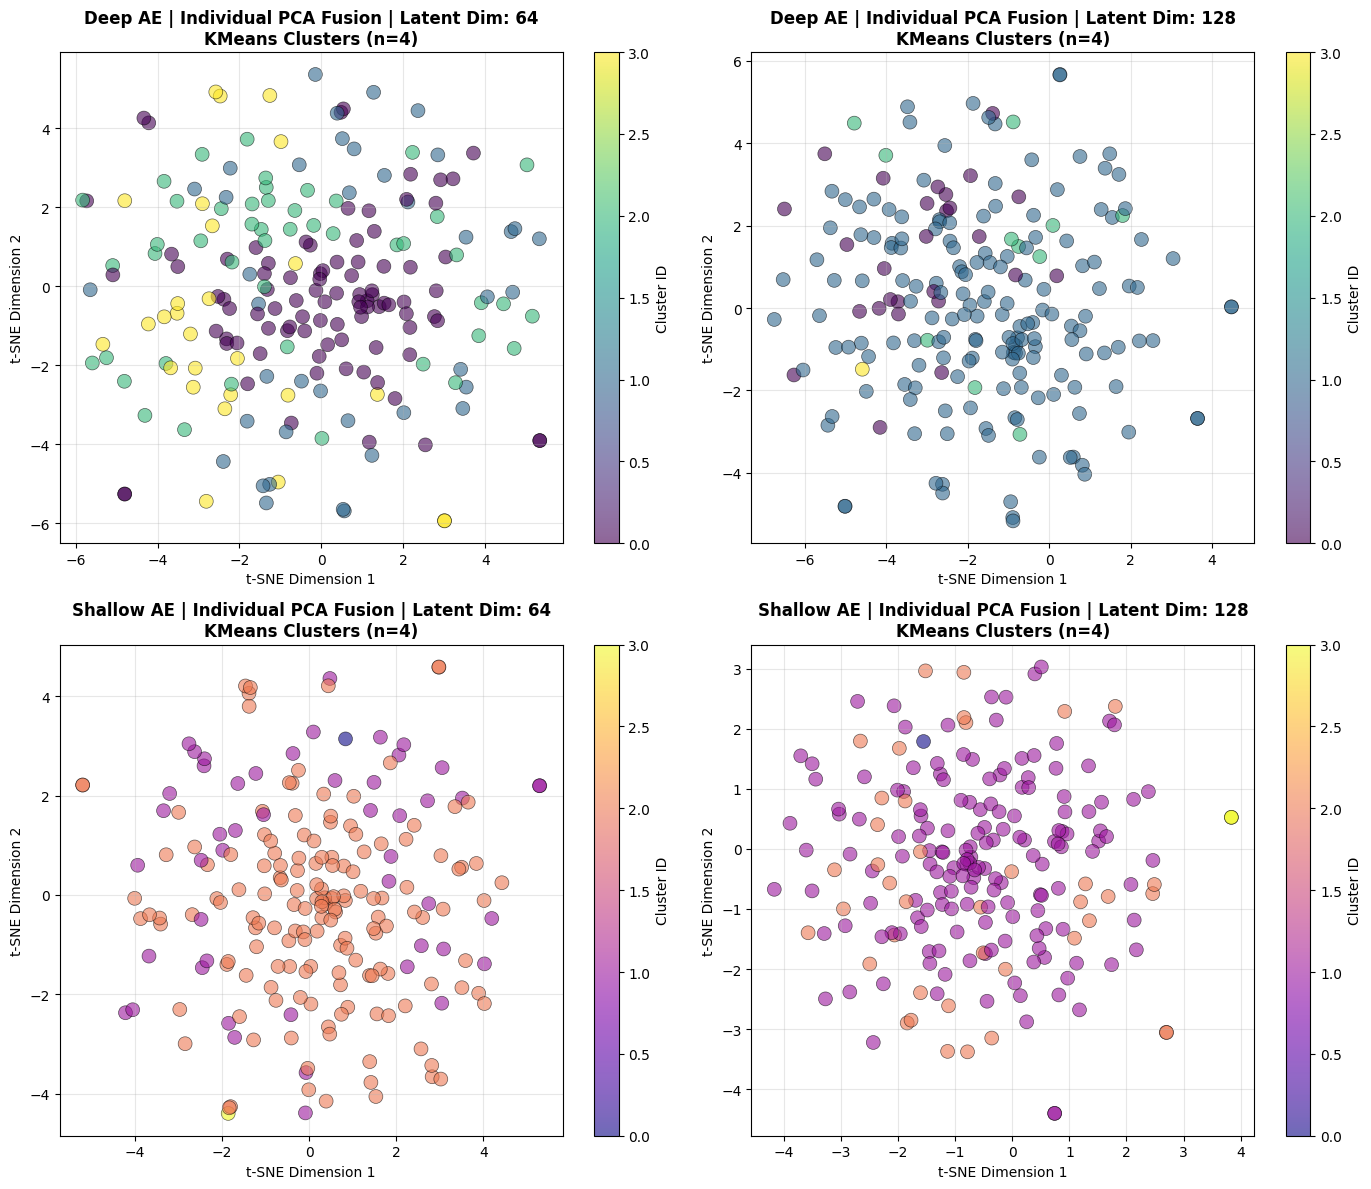


✅ Visualization completed for 2 latent dimensions!
   Top row: Deep Autoencoder (Input → 256 → Latent → 256 → Output)
   Bottom row: Shallow Autoencoder (Input → Latent → Output)
   Each plot shows KMeans clustering in 2D space (via t-SNE)


In [7]:

# VISUALIZATION: Deep and Shallow Autoencoder Comparisons
print("=" * 100)
print("📊 AUTOENCODER VISUALIZATION COMPARISON")
print("=" * 100)

n_latents = len(ae_scores)
fig, axes = plt.subplots(2, n_latents, figsize=(7 * n_latents, 12))

# Handle single latent dimension case
if n_latents == 1:
    axes = axes.reshape(-1, 1)

y = labels.values.ravel()
n_clusters = len(np.unique(y))

for idx, latent_dim in enumerate(ae_scores.keys()):
    # ============================================================================
    # DEEP AUTOENCODER VISUALIZATION
    # ============================================================================
    # Get deep autoencoder embeddings
    embeddings_deep_np = ae_embeddings[latent_dim]
    
    # Apply t-SNE for 2D visualization (if latent_dim > 2)
    if latent_dim > 2:
        tsne_deep = TSNE(n_components=2, random_state=42, perplexity=min(30, len(embeddings_deep_np)-1))
        embeddings_deep_2d = tsne_deep.fit_transform(embeddings_deep_np)
    else:
        embeddings_deep_2d = embeddings_deep_np[:, :2]
    
    # Use KMeans for cluster assignment
    kmeans_deep = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
    cluster_labels_deep = kmeans_deep.fit_predict(embeddings_deep_np)
    
    # Plot deep autoencoder
    ax_deep = axes[0, idx]
    scatter_deep = ax_deep.scatter(embeddings_deep_2d[:, 0], embeddings_deep_2d[:, 1], 
                                  c=cluster_labels_deep, cmap='viridis', 
                                  s=100, alpha=0.6, edgecolors='black', linewidth=0.5)
    
    ax_deep.set_title(f'Deep AE | Individual PCA Fusion | Latent Dim: {latent_dim}\nKMeans Clusters (n={n_clusters})', 
                     fontsize=12, fontweight='bold')
    ax_deep.set_xlabel('t-SNE Dimension 1' if latent_dim > 2 else 'Latent Dimension 1', fontsize=10)
    ax_deep.set_ylabel('t-SNE Dimension 2' if latent_dim > 2 else 'Latent Dimension 2', fontsize=10)
    ax_deep.grid(True, alpha=0.3)
    plt.colorbar(scatter_deep, ax=ax_deep, label='Cluster ID')
    
    # ============================================================================
    # SHALLOW AUTOENCODER VISUALIZATION
    # ============================================================================
    # Get shallow autoencoder embeddings
    embeddings_shallow_np = shallow_ae_embeddings[latent_dim]
    
    # Apply t-SNE for 2D visualization (if latent_dim > 2)
    if latent_dim > 2:
        tsne_shallow = TSNE(n_components=2, random_state=42, perplexity=min(30, len(embeddings_shallow_np)-1))
        embeddings_shallow_2d = tsne_shallow.fit_transform(embeddings_shallow_np)
    else:
        embeddings_shallow_2d = embeddings_shallow_np[:, :2]
    
    # Use KMeans for cluster assignment
    kmeans_shallow = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
    cluster_labels_shallow = kmeans_shallow.fit_predict(embeddings_shallow_np)
    
    # Plot shallow autoencoder
    ax_shallow = axes[1, idx]
    scatter_shallow = ax_shallow.scatter(embeddings_shallow_2d[:, 0], embeddings_shallow_2d[:, 1], 
                                       c=cluster_labels_shallow, cmap='plasma', 
                                       s=100, alpha=0.6, edgecolors='black', linewidth=0.5)
    
    ax_shallow.set_title(f'Shallow AE | Individual PCA Fusion | Latent Dim: {latent_dim}\nKMeans Clusters (n={n_clusters})', 
                        fontsize=12, fontweight='bold')
    ax_shallow.set_xlabel('t-SNE Dimension 1' if latent_dim > 2 else 'Latent Dimension 1', fontsize=10)
    ax_shallow.set_ylabel('t-SNE Dimension 2' if latent_dim > 2 else 'Latent Dimension 2', fontsize=10)
    ax_shallow.grid(True, alpha=0.3)
    plt.colorbar(scatter_shallow, ax=ax_shallow, label='Cluster ID')

plt.tight_layout()
plt.show()

print(f"\n✅ Visualization completed for {n_latents} latent dimensions!")
print(f"   Top row: Deep Autoencoder (Input → 256 → Latent → 256 → Output)")
print(f"   Bottom row: Shallow Autoencoder (Input → Latent → Output)")
print(f"   Each plot shows KMeans clustering in 2D space (via t-SNE)")

In [8]:
# Display Evaluation Results in Tables
print("=" * 100)
print("📊 DEEP AUTOENCODER PIPELINE EVALUATION RESULTS")
print("=" * 100)

# ============================================================================
# TABLE 1: DEEP AE - ML MODEL PERFORMANCE METRICS
# ============================================================================
print("\n" + "=" * 100)
print("TABLE 1: DEEP AUTOENCODER - MACHINE LEARNING MODEL PERFORMANCE")
print("=" * 100)

# Collect all ML model results for deep autoencoder
ml_results_table_deep = []

for latent_dim, results in ae_scores.items():
    for model_name, metrics in results['ml_models'].items():
        row = {
            'Latent Dim': latent_dim,
            'Model': model_name,
            'Accuracy': metrics['accuracy'],
            'F1-Macro': metrics['f1_macro'],
            'F1-Micro': metrics['f1_micro'],
            'Precision': metrics['precision'],
            'Recall': metrics['recall'],
            'AUC': metrics['auc'] if metrics['auc'] is not None else np.nan,
            'C-Index': metrics['c_index'] if metrics['c_index'] is not None else np.nan,
            'CV-Mean': metrics['cv_mean'],
            'CV-Std': metrics['cv_std']
        }
        ml_results_table_deep.append(row)

# Create DataFrame
ml_df_deep = pd.DataFrame(ml_results_table_deep)

# Display full table with proper formatting
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.float_format', '{:.4f}'.format)

print("\n📋 Deep AE Complete ML Model Performance Table:")
print("-" * 100)
print(ml_df_deep.to_string(index=False))

# ============================================================================
# TABLE 2: DEEP AE - STABILITY & CLUSTERING METRICS
# ============================================================================
print("\n\n" + "=" * 100)
print("TABLE 2: DEEP AUTOENCODER - STABILITY & CLUSTERING METRICS")
print("=" * 100)

# Collect stability metrics for deep autoencoder
stability_table_deep = []

for latent_dim, results in ae_scores.items():
    row = {
        'Latent Dim': latent_dim,
        'ARI': results['ari'],
        'NMI': results['nmi'],
        'Silhouette': results['silhouette'],
        'Calinski-Harabasz': results['calinski_harabasz'],
        'Davies-Bouldin': results['davies_bouldin'],
        'Reconstruction Error': results['reconstruction_error'],
        'Embedding Shape': f"{results['embeddings_shape'][0]}x{results['embeddings_shape'][1]}"
    }
    stability_table_deep.append(row)

# Create DataFrame
stability_df_deep = pd.DataFrame(stability_table_deep)

print("\n📋 Deep AE Complete Stability & Clustering Metrics Table:")
print("-" * 100)
print(stability_df_deep.to_string(index=False))

📊 DEEP AUTOENCODER PIPELINE EVALUATION RESULTS

TABLE 1: DEEP AUTOENCODER - MACHINE LEARNING MODEL PERFORMANCE

📋 Deep AE Complete ML Model Performance Table:
----------------------------------------------------------------------------------------------------
 Latent Dim              Model  Accuracy  F1-Macro  F1-Micro  Precision  Recall    AUC  C-Index  CV-Mean  CV-Std
         64       RandomForest    0.5854    0.3431    0.5854     0.3549  0.3732 0.7999   0.4691   0.6390  0.0358
         64   GradientBoosting    0.5366    0.3819    0.5366     0.4026  0.3824 0.6479   0.4850   0.5707  0.0609
         64 LogisticRegression    0.7073    0.5927    0.7073     0.6250  0.5847 0.7282   0.4198   0.6390  0.0807
         64            SVM_RBF    0.6098    0.3573    0.6098     0.3551  0.3959 0.8549   0.4815   0.6244  0.0502
         64                KNN    0.6341    0.4878    0.6341     0.6438  0.5097 0.7381   0.3862   0.6195  0.0502
         64         NaiveBayes    0.4634    0.3654    0.4634  

In [9]:
# Display Shallow Autoencoder Results in Separate Tables
print("=" * 100)
print("📊 SHALLOW AUTOENCODER PIPELINE EVALUATION RESULTS")
print("=" * 100)

# ============================================================================
# TABLE 3: SHALLOW AE - ML MODEL PERFORMANCE METRICS
# ============================================================================
print("\n" + "=" * 100)
print("TABLE 3: SHALLOW AUTOENCODER - MACHINE LEARNING MODEL PERFORMANCE")
print("=" * 100)

# Collect all ML model results for shallow autoencoder
ml_results_table_shallow = []

for latent_dim, results in shallow_ae_scores.items():
    for model_name, metrics in results['ml_models'].items():
        row = {
            'Latent Dim': latent_dim,
            'Model': model_name,
            'Accuracy': metrics['accuracy'],
            'F1-Macro': metrics['f1_macro'],
            'F1-Micro': metrics['f1_micro'],
            'Precision': metrics['precision'],
            'Recall': metrics['recall'],
            'AUC': metrics['auc'] if metrics['auc'] is not None else np.nan,
            'C-Index': metrics['c_index'] if metrics['c_index'] is not None else np.nan,
            'CV-Mean': metrics['cv_mean'],
            'CV-Std': metrics['cv_std']
        }
        ml_results_table_shallow.append(row)

# Create DataFrame
ml_df_shallow = pd.DataFrame(ml_results_table_shallow)

print("\n📋 Shallow AE Complete ML Model Performance Table:")
print("-" * 100)
print(ml_df_shallow.to_string(index=False))

# ============================================================================
# TABLE 4: SHALLOW AE - STABILITY & CLUSTERING METRICS
# ============================================================================
print("\n\n" + "=" * 100)
print("TABLE 4: SHALLOW AUTOENCODER - STABILITY & CLUSTERING METRICS")
print("=" * 100)

# Collect stability metrics for shallow autoencoder
stability_table_shallow = []

for latent_dim, results in shallow_ae_scores.items():
    row = {
        'Latent Dim': latent_dim,
        'ARI': results['ari'],
        'NMI': results['nmi'],
        'Silhouette': results['silhouette'],
        'Calinski-Harabasz': results['calinski_harabasz'],
        'Davies-Bouldin': results['davies_bouldin'],
        'Reconstruction Error': results['reconstruction_error'],
        'Embedding Shape': f"{results['embeddings_shape'][0]}x{results['embeddings_shape'][1]}"
    }
    stability_table_shallow.append(row)

# Create DataFrame
stability_df_shallow = pd.DataFrame(stability_table_shallow)

print("\n📋 Shallow AE Complete Stability & Clustering Metrics Table:")
print("-" * 100)
print(stability_df_shallow.to_string(index=False))

# ============================================================================
# COMPARISON SUMMARY: DEEP vs SHALLOW AUTOENCODER
# ============================================================================
print("\n\n" + "=" * 100)
print("📊 ARCHITECTURE COMPARISON SUMMARY")
print("=" * 100)

print("\n🏗️  Architecture Details:")
print("   Deep AE:    Input → 256 → Latent → 256 → Output (2 hidden layers)")
print("   Shallow AE: Input → Latent → Output (0 hidden layers)")

print("\n📈 Performance Summary by Latent Dimension:")
print("-" * 100)

for latent_dim in ae_scores.keys():
    print(f"\n📊 Latent Dimension: {latent_dim}")
    print("-" * 50)
    
    # Get best performing model for each architecture
    deep_results = ae_scores[latent_dim]['ml_models']
    shallow_results = shallow_ae_scores[latent_dim]['ml_models']
    
    # Find best accuracy for each
    deep_best_acc = max([metrics['accuracy'] for metrics in deep_results.values()])
    shallow_best_acc = max([metrics['accuracy'] for metrics in shallow_results.values()])
    
    deep_best_f1 = max([metrics['f1_macro'] for metrics in deep_results.values()])
    shallow_best_f1 = max([metrics['f1_macro'] for metrics in shallow_results.values()])
    
    print(f"   Deep AE    - Best Accuracy: {deep_best_acc:.4f} | Best F1-Macro: {deep_best_f1:.4f}")
    print(f"   Shallow AE - Best Accuracy: {shallow_best_acc:.4f} | Best F1-Macro: {shallow_best_f1:.4f}")
    
    # Clustering comparison
    print(f"   Deep AE    - ARI: {ae_scores[latent_dim]['ari']:.4f} | Silhouette: {ae_scores[latent_dim]['silhouette']:.4f}")
    print(f"   Shallow AE - ARI: {shallow_ae_scores[latent_dim]['ari']:.4f} | Silhouette: {shallow_ae_scores[latent_dim]['silhouette']:.4f}")
    
    # Reconstruction error comparison
    print(f"   Deep AE    - Recon Error: {ae_scores[latent_dim]['reconstruction_error']:.6f}")
    print(f"   Shallow AE - Recon Error: {shallow_ae_scores[latent_dim]['reconstruction_error']:.6f}")

print(f"\n{'='*100}")
print(f"✅ COMPARATIVE ANALYSIS COMPLETED!")
print(f"{'='*100}")

📊 SHALLOW AUTOENCODER PIPELINE EVALUATION RESULTS

TABLE 3: SHALLOW AUTOENCODER - MACHINE LEARNING MODEL PERFORMANCE

📋 Shallow AE Complete ML Model Performance Table:
----------------------------------------------------------------------------------------------------
 Latent Dim              Model  Accuracy  F1-Macro  F1-Micro  Precision  Recall    AUC  C-Index  CV-Mean  CV-Std
         64       RandomForest    0.5122    0.2636    0.5122     0.3125  0.3050 0.6981   0.6173   0.5854  0.0597
         64   GradientBoosting    0.4634    0.3252    0.4634     0.3438  0.3281 0.6852   0.6155   0.5463  0.0452
         64 LogisticRegression    0.5366    0.4425    0.5366     0.4508  0.4413 0.6979   0.4727   0.5561  0.0625
         64            SVM_RBF    0.5854    0.3365    0.5854     0.3466  0.3732 0.7942   0.6049   0.5902  0.0390
         64                KNN    0.5610    0.4480    0.5610     0.6517  0.4798 0.7162   0.4524   0.4829  0.0968
         64         NaiveBayes    0.3659    0.2961   

📈 AUC-ROC CURVES FOR DEEP AND SHALLOW AUTOENCODERS


f:\BRACU\Thesis Thingy[T2510589]\DATASET 2\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:1281: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(
f:\BRACU\Thesis Thingy[T2510589]\DATASET 2\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:1281: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(
f:\BRACU\Thesis Thingy[T2510589]\DATASET 2\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:1281: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(
f:\BRACU\Thesis Thingy[T2510589]\DATA

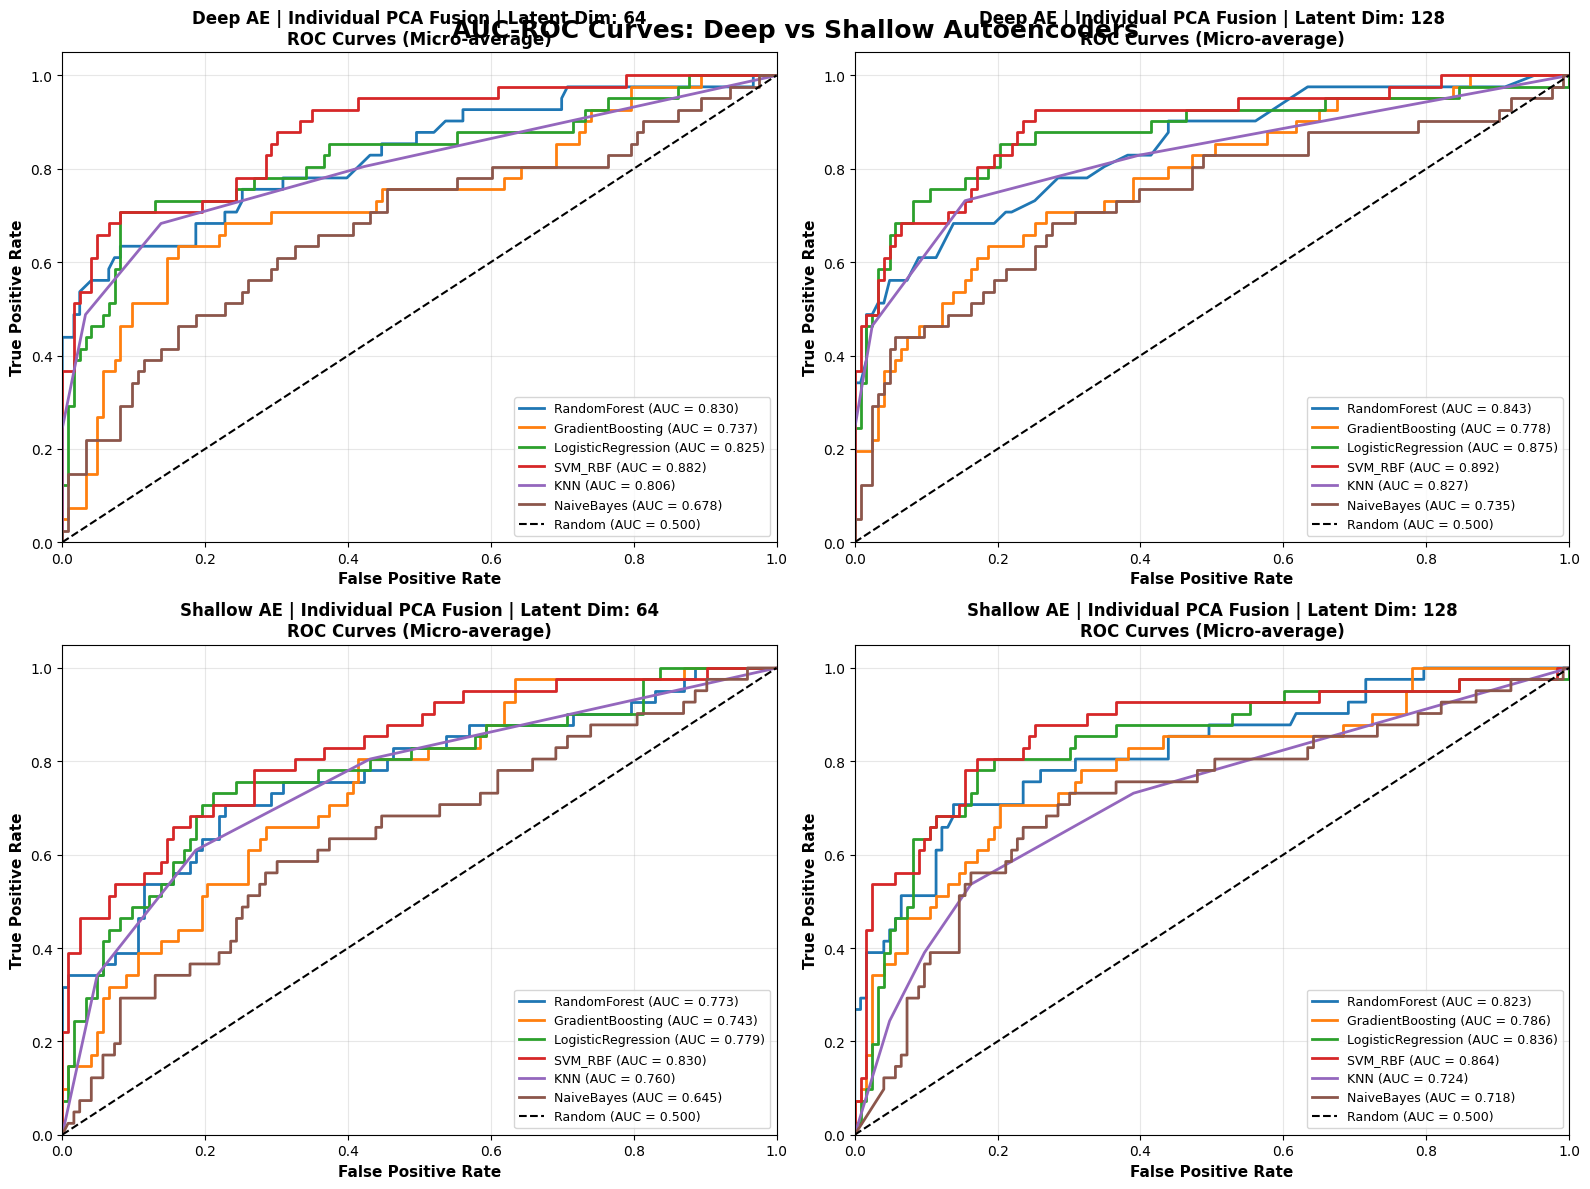


✅ ROC curves plotted for 2 latent dimensions!
   Top row: Deep Autoencoder (Input → 256 → Latent → 256 → Output)
   Bottom row: Shallow Autoencoder (Input → Latent → Output)
   Each subplot shows all 6 models for comparison
   Multiclass (micro-average) ROC curves

📊 AUC SUMMARY TABLES

📋 Deep AE - AUC Scores by Configuration and Model:
----------------------------------------------------------------------------------------------------
 Latent Dim              Model    AUC
         64       RandomForest 0.7999
         64   GradientBoosting 0.6479
         64 LogisticRegression 0.7282
         64            SVM_RBF 0.8549
         64                KNN 0.7381
         64         NaiveBayes 0.5479
        128       RandomForest 0.8333
        128   GradientBoosting 0.7304
        128 LogisticRegression 0.8417
        128            SVM_RBF 0.8716
        128                KNN 0.7875
        128         NaiveBayes 0.6180

📋 Shallow AE - AUC Scores by Configuration and Model:
----------

In [10]:
# Plot AUC-ROC Curves for Deep and Shallow Autoencoders
print("=" * 100)
print("📈 AUC-ROC CURVES FOR DEEP AND SHALLOW AUTOENCODERS")
print("=" * 100)

from sklearn.metrics import roc_curve, auc
from itertools import cycle

# Get latent dimensions
latent_dims = list(ae_scores.keys())
n_latents = len(latent_dims)

# Create subplots: 2 rows (Deep, Shallow) x n_latents columns
fig, axes = plt.subplots(2, n_latents, figsize=(8 * n_latents, 12))

# Handle single latent dimension case
if n_latents == 1:
    axes = axes.reshape(-1, 1)

# Get labels and classes
y = labels.values.ravel()
classes = np.unique(y)
n_classes = len(classes)

for idx, latent_dim in enumerate(latent_dims):
    
    # ============================================================================
    # DEEP AUTOENCODER ROC CURVES
    # ============================================================================
    ax_deep = axes[0, idx]
    deep_results = ae_scores[latent_dim]
    embeddings_deep_np = ae_embeddings[latent_dim]
    
    # Store model colors for consistency
    model_colors = {}
    color_iter = cycle(['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b'])
    
    for model_name in deep_results['ml_models'].keys():
        model_colors[model_name] = next(color_iter)
    
    # Train each model and plot ROC curve for deep autoencoder
    for model_name, metrics in deep_results['ml_models'].items():
        # Define model
        if model_name == 'RandomForest':
            model = RandomForestClassifier(n_estimators=100, random_state=42, max_depth=10)
        elif model_name == 'GradientBoosting':
            model = GradientBoostingClassifier(n_estimators=100, random_state=42, max_depth=5)
        elif model_name == 'LogisticRegression':
            model = LogisticRegression(max_iter=1000, random_state=42, multi_class='ovr')
        elif model_name == 'SVM_RBF':
            model = SVC(kernel='rbf', random_state=42, probability=True)
        elif model_name == 'KNN':
            model = KNeighborsClassifier(n_neighbors=4)
        elif model_name == 'NaiveBayes':
            model = GaussianNB()
        
        # Split data for proper evaluation
        X_train, X_test, y_train, y_test = train_test_split(
            embeddings_deep_np, y, test_size=0.2, random_state=42, stratify=y
        )
        
        # Train and predict
        model.fit(X_train, y_train)
        y_score = model.predict_proba(X_test)
        
        # Compute ROC curve
        if n_classes == 2:
            y_test_bin = label_binarize(y_test, classes=classes)
            fpr, tpr, _ = roc_curve(y_test_bin.ravel(), y_score[:, 1])
            roc_auc = auc(fpr, tpr)
            ax_deep.plot(fpr, tpr, color=model_colors[model_name], lw=2,
                        label=f'{model_name} (AUC = {roc_auc:.3f})')
        else:
            y_test_bin = label_binarize(y_test, classes=classes)
            fpr, tpr, _ = roc_curve(y_test_bin.ravel(), y_score.ravel())
            roc_auc = auc(fpr, tpr)
            ax_deep.plot(fpr, tpr, color=model_colors[model_name], lw=2,
                        label=f'{model_name} (AUC = {roc_auc:.3f})')
    
    # Plot diagonal line for deep AE
    ax_deep.plot([0, 1], [0, 1], 'k--', lw=1.5, label='Random (AUC = 0.500)')
    
    # Formatting for deep AE
    ax_deep.set_xlim([0.0, 1.0])
    ax_deep.set_ylim([0.0, 1.05])
    ax_deep.set_xlabel('False Positive Rate', fontsize=11, fontweight='bold')
    ax_deep.set_ylabel('True Positive Rate', fontsize=11, fontweight='bold')
    ax_deep.set_title(f'Deep AE | Individual PCA Fusion | Latent Dim: {latent_dim}\nROC Curves ({"Binary" if n_classes == 2 else "Micro-average"})', 
                     fontsize=12, fontweight='bold')
    ax_deep.legend(loc="lower right", fontsize=9)
    ax_deep.grid(True, alpha=0.3)
    
    # ============================================================================
    # SHALLOW AUTOENCODER ROC CURVES
    # ============================================================================
    ax_shallow = axes[1, idx]
    shallow_results = shallow_ae_scores[latent_dim]
    embeddings_shallow_np = shallow_ae_embeddings[latent_dim]
    
    # Train each model and plot ROC curve for shallow autoencoder
    for model_name, metrics in shallow_results['ml_models'].items():
        # Define model (same as above)
        if model_name == 'RandomForest':
            model = RandomForestClassifier(n_estimators=100, random_state=42, max_depth=10)
        elif model_name == 'GradientBoosting':
            model = GradientBoostingClassifier(n_estimators=100, random_state=42, max_depth=5)
        elif model_name == 'LogisticRegression':
            model = LogisticRegression(max_iter=1000, random_state=42, multi_class='ovr')
        elif model_name == 'SVM_RBF':
            model = SVC(kernel='rbf', random_state=42, probability=True)
        elif model_name == 'KNN':
            model = KNeighborsClassifier(n_neighbors=4)
        elif model_name == 'NaiveBayes':
            model = GaussianNB()
        
        # Split data for proper evaluation
        X_train, X_test, y_train, y_test = train_test_split(
            embeddings_shallow_np, y, test_size=0.2, random_state=42, stratify=y
        )
        
        # Train and predict
        model.fit(X_train, y_train)
        y_score = model.predict_proba(X_test)
        
        # Compute ROC curve
        if n_classes == 2:
            y_test_bin = label_binarize(y_test, classes=classes)
            fpr, tpr, _ = roc_curve(y_test_bin.ravel(), y_score[:, 1])
            roc_auc = auc(fpr, tpr)
            ax_shallow.plot(fpr, tpr, color=model_colors[model_name], lw=2,
                           label=f'{model_name} (AUC = {roc_auc:.3f})')
        else:
            y_test_bin = label_binarize(y_test, classes=classes)
            fpr, tpr, _ = roc_curve(y_test_bin.ravel(), y_score.ravel())
            roc_auc = auc(fpr, tpr)
            ax_shallow.plot(fpr, tpr, color=model_colors[model_name], lw=2,
                           label=f'{model_name} (AUC = {roc_auc:.3f})')
    
    # Plot diagonal line for shallow AE
    ax_shallow.plot([0, 1], [0, 1], 'k--', lw=1.5, label='Random (AUC = 0.500)')
    
    # Formatting for shallow AE
    ax_shallow.set_xlim([0.0, 1.0])
    ax_shallow.set_ylim([0.0, 1.05])
    ax_shallow.set_xlabel('False Positive Rate', fontsize=11, fontweight='bold')
    ax_shallow.set_ylabel('True Positive Rate', fontsize=11, fontweight='bold')
    ax_shallow.set_title(f'Shallow AE | Individual PCA Fusion | Latent Dim: {latent_dim}\nROC Curves ({"Binary" if n_classes == 2 else "Micro-average"})', 
                        fontsize=12, fontweight='bold')
    ax_shallow.legend(loc="lower right", fontsize=9)
    ax_shallow.grid(True, alpha=0.3)

plt.tight_layout()
plt.suptitle('AUC-ROC Curves: Deep vs Shallow Autoencoders', 
            fontsize=18, fontweight='bold', y=0.98)
plt.show()

print(f"\n✅ ROC curves plotted for {n_latents} latent dimensions!")
print(f"   Top row: Deep Autoencoder (Input → 256 → Latent → 256 → Output)")
print(f"   Bottom row: Shallow Autoencoder (Input → Latent → Output)")
print(f"   Each subplot shows all 6 models for comparison")
print(f"   {"Binary classification" if n_classes == 2 else "Multiclass (micro-average) ROC curves"}")

# ============================================================================
# Summary Tables: AUC Scores for Deep and Shallow Autoencoders
# ============================================================================
print("\n" + "=" * 100)
print("📊 AUC SUMMARY TABLES")
print("=" * 100)

# Deep AE AUC Summary
auc_summary_deep = []
for latent_dim in latent_dims:
    results = ae_scores[latent_dim]
    
    for model_name, metrics in results['ml_models'].items():
        auc_val = metrics['auc'] if metrics['auc'] is not None else np.nan
        auc_summary_deep.append({
            'Latent Dim': latent_dim,
            'Model': model_name,
            'AUC': auc_val
        })

auc_df_deep = pd.DataFrame(auc_summary_deep)
print("\n📋 Deep AE - AUC Scores by Configuration and Model:")
print("-" * 100)
print(auc_df_deep.to_string(index=False))

# Shallow AE AUC Summary
auc_summary_shallow = []
for latent_dim in latent_dims:
    results = shallow_ae_scores[latent_dim]
    
    for model_name, metrics in results['ml_models'].items():
        auc_val = metrics['auc'] if metrics['auc'] is not None else np.nan
        auc_summary_shallow.append({
            'Latent Dim': latent_dim,
            'Model': model_name,
            'AUC': auc_val
        })

auc_df_shallow = pd.DataFrame(auc_summary_shallow)
print("\n📋 Shallow AE - AUC Scores by Configuration and Model:")
print("-" * 100)
print(auc_df_shallow.to_string(index=False))

# Survival Analysis for Early Integration PCA + Autoencoder Models

Now let's perform survival analysis using the best performing configuration from our early integration approach to understand the relationship between predicted cancer subtypes and patient outcomes.

In [11]:
# Load and prepare survival data
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from lifelines import KaplanMeierFitter, CoxPHFitter
from lifelines.statistics import logrank_test, multivariate_logrank_test
from lifelines.plotting import plot_lifetimes
import warnings
warnings.filterwarnings('ignore')

# Load survival data
survival_df = pd.read_csv("../TCGA-SARC.survival.tsv", sep='\t')
print(f"Survival data shape: {survival_df.shape}")
print(f"Survival data columns: {survival_df.columns.tolist()}")
print(f"Sample survival data:")
print(survival_df.head())

# Check for missing values
print(f"\nMissing values:")
print(survival_df.isnull().sum())

# Basic statistics
print(f"\nSurvival statistics:")
print(f"OS.time range: {survival_df['OS.time'].min():.1f} - {survival_df['OS.time'].max():.1f} months")
print(f"Event rate (deaths): {survival_df['OS'].mean():.3f} ({survival_df['OS'].sum()} out of {len(survival_df)})")
print(f"Median follow-up time: {survival_df['OS.time'].median():.1f} months")

Survival data shape: (269, 4)
Survival data columns: ['sample', 'OS.time', 'OS', '_PATIENT']
Sample survival data:
             sample  OS.time  OS      _PATIENT
0  TCGA-MB-A5YA-01A  15.0000   0  TCGA-MB-A5YA
1  TCGA-3R-A8YX-01A  17.0000   1  TCGA-3R-A8YX
2  TCGA-HS-A5N8-01A  22.0000   1  TCGA-HS-A5N8
3  TCGA-RN-A68Q-01A  22.0000   0  TCGA-RN-A68Q
4  TCGA-X6-A7W8-01A  24.0000   1  TCGA-X6-A7W8

Missing values:
sample      0
OS.time     0
OS          0
_PATIENT    0
dtype: int64

Survival statistics:
OS.time range: 15.0 - 5723.0 months
Event rate (deaths): 0.379 (102 out of 269)
Median follow-up time: 959.0 months


In [17]:
# BETTER APPROACH: Use existing embeddings instead of retraining
print("Using existing best model embeddings for survival analysis...")
print("=" * 60)

# Find best configuration
best_deep_auc = 0
best_deep_config = None
best_shallow_auc = 0 
best_shallow_config = None

for latent_dim in latent_dims:
    # Check deep AE results
    for model_name, metrics in ae_scores[latent_dim]['ml_models'].items():
        if metrics['auc'] is not None and metrics['auc'] > best_deep_auc:
            best_deep_auc = metrics['auc']
            best_deep_config = (latent_dim, model_name, 'Deep')
    
    # Check shallow AE results  
    for model_name, metrics in shallow_ae_scores[latent_dim]['ml_models'].items():
        if metrics['auc'] is not None and metrics['auc'] > best_shallow_auc:
            best_shallow_auc = metrics['auc']
            best_shallow_config = (latent_dim, model_name, 'Shallow')

# Choose overall best
if best_deep_auc >= best_shallow_auc:
    best_latent, best_model, ae_type = best_deep_config
    best_auc = best_deep_auc
    # Use existing deep AE embeddings
    best_embeddings_np = ae_embeddings[best_latent]
else:
    best_latent, best_model, ae_type = best_shallow_config  
    best_auc = best_shallow_auc
    # Use existing shallow AE embeddings
    best_embeddings_np = shallow_ae_embeddings[best_latent]

print(f"✨ Best Configuration: {ae_type} AE (latent={best_latent}) + {best_model} (AUC={best_auc:.4f})")
print(f"📊 Using existing embeddings shape: {best_embeddings_np.shape}")

# Train classifier on ALL samples using existing embeddings
y_labels = labels.values.ravel()

# Initialize and train the best classifier on full dataset
if best_model == 'RandomForest':
    best_classifier = RandomForestClassifier(n_estimators=100, random_state=42, max_depth=10)
elif best_model == 'GradientBoosting':
    best_classifier = GradientBoostingClassifier(n_estimators=100, random_state=42, max_depth=5)
elif best_model == 'LogisticRegression':
    best_classifier = LogisticRegression(max_iter=1000, random_state=42, multi_class='ovr')
elif best_model == 'SVM_RBF':
    best_classifier = SVC(kernel='rbf', random_state=42, probability=True)
elif best_model == 'KNN':
    best_classifier = KNeighborsClassifier(n_neighbors=4)
elif best_model == 'NaiveBayes':
    best_classifier = GaussianNB()

# Train on ALL samples for survival analysis
best_classifier.fit(best_embeddings_np, y_labels)
print("✅ Classifier trained on existing embeddings!")

# Get predictions for all samples
all_predictions = best_classifier.predict(best_embeddings_np)
all_prediction_probs = best_classifier.predict_proba(best_embeddings_np)

print(f"📊 Prediction summary:")
print(f"   Total samples: {len(all_predictions)}")
print(f"   Unique subtypes: {np.unique(all_predictions)}")
print(f"   Distribution: {np.bincount(all_predictions)}")

Using existing best model embeddings for survival analysis...
✨ Best Configuration: Deep AE (latent=128) + SVM_RBF (AUC=0.8716)
📊 Using existing embeddings shape: (205, 128)
✅ Classifier trained on existing embeddings!
📊 Prediction summary:
   Total samples: 205
   Unique subtypes: [0 1 2 3]
   Distribution: [ 52  15 109  29]


In [18]:
# Create predictions DataFrame and merge with survival data
print("Creating predictions and merging with survival data...")
print("=" * 55)

# Get sample IDs from the labels index
sample_ids = labels.index.tolist()

# Create predictions DataFrame
predictions_df = pd.DataFrame({
    'sample': sample_ids,
    'predicted_subtype': all_predictions,
    'subtype_0_prob': all_prediction_probs[:, 0],
    'subtype_1_prob': all_prediction_probs[:, 1] if all_prediction_probs.shape[1] > 1 else 0,
    'subtype_2_prob': all_prediction_probs[:, 2] if all_prediction_probs.shape[1] > 2 else 0,
    'subtype_3_prob': all_prediction_probs[:, 3] if all_prediction_probs.shape[1] > 3 else 0,
    'max_prob': np.max(all_prediction_probs, axis=1)  # Confidence score
})

print(f"📊 Predictions DataFrame created:")
print(f"   Shape: {predictions_df.shape}")
print(f"   Predicted subtypes distribution:")
print(predictions_df['predicted_subtype'].value_counts().sort_index())

# Align sample names for merging
survival_df['sample_clean'] = survival_df['sample'].str.replace('-01A', '', regex=False)
predictions_df['sample_clean'] = predictions_df['sample'].str.replace('-01A', '', regex=False)

# Merge survival data with predictions
survival_analysis_df = pd.merge(
    survival_df, 
    predictions_df, 
    left_on='sample_clean', 
    right_on='sample_clean', 
    how='inner'
)

print(f"\n🔗 Merge results:")
print(f"   Merged data shape: {survival_analysis_df.shape}")
print(f"   Successfully matched: {len(survival_analysis_df)} samples")

if len(survival_analysis_df) == 0:
    print("⚠️  No matching samples found. Trying direct merge...")
    survival_analysis_df = pd.merge(
        survival_df, 
        predictions_df, 
        left_on='sample', 
        right_on='sample', 
        how='inner'
    )
    print(f"   Direct merge result: {survival_analysis_df.shape}")

if len(survival_analysis_df) > 0:
    # Clean up column names - pandas creates sample_x and sample_y during merge
    if 'sample_x' in survival_analysis_df.columns:
        survival_analysis_df = survival_analysis_df.rename(columns={'sample_x': 'sample'})
        if 'sample_y' in survival_analysis_df.columns:
            survival_analysis_df = survival_analysis_df.drop(columns=['sample_y'])
    
    print(f"\n📈 Survival cohort subtype distribution:")
    print(survival_analysis_df['predicted_subtype'].value_counts().sort_index())
    print(f"\n📋 Sample of merged data:")
    print(survival_analysis_df[['sample', 'OS.time', 'OS', 'predicted_subtype', 'max_prob']].head())
else:
    print("❌ Warning: No samples could be matched between survival and prediction data")
    print("Sample names in survival data:", survival_df['sample'].head().tolist())
    print("Sample names in prediction data:", predictions_df['sample'].head().tolist())

Creating predictions and merging with survival data...
📊 Predictions DataFrame created:
   Shape: (205, 7)
   Predicted subtypes distribution:
predicted_subtype
0     52
1     15
2    109
3     29
Name: count, dtype: int64

🔗 Merge results:
   Merged data shape: (203, 12)
   Successfully matched: 203 samples

📈 Survival cohort subtype distribution:
predicted_subtype
0     51
1     15
2    108
3     29
Name: count, dtype: int64

📋 Sample of merged data:
             sample  OS.time  OS  predicted_subtype  max_prob
0  TCGA-MB-A5YA-01A  15.0000   0                  2    0.9448
1  TCGA-3R-A8YX-01A  17.0000   1                  0    0.7785
2  TCGA-HS-A5N8-01A  22.0000   1                  2    0.9264
3  TCGA-X6-A7W8-01A  24.0000   1                  2    0.3553
4  TCGA-JV-A5VF-01A  32.0000   1                  2    0.8226


🎨 Creating comprehensive survival analysis visualization...


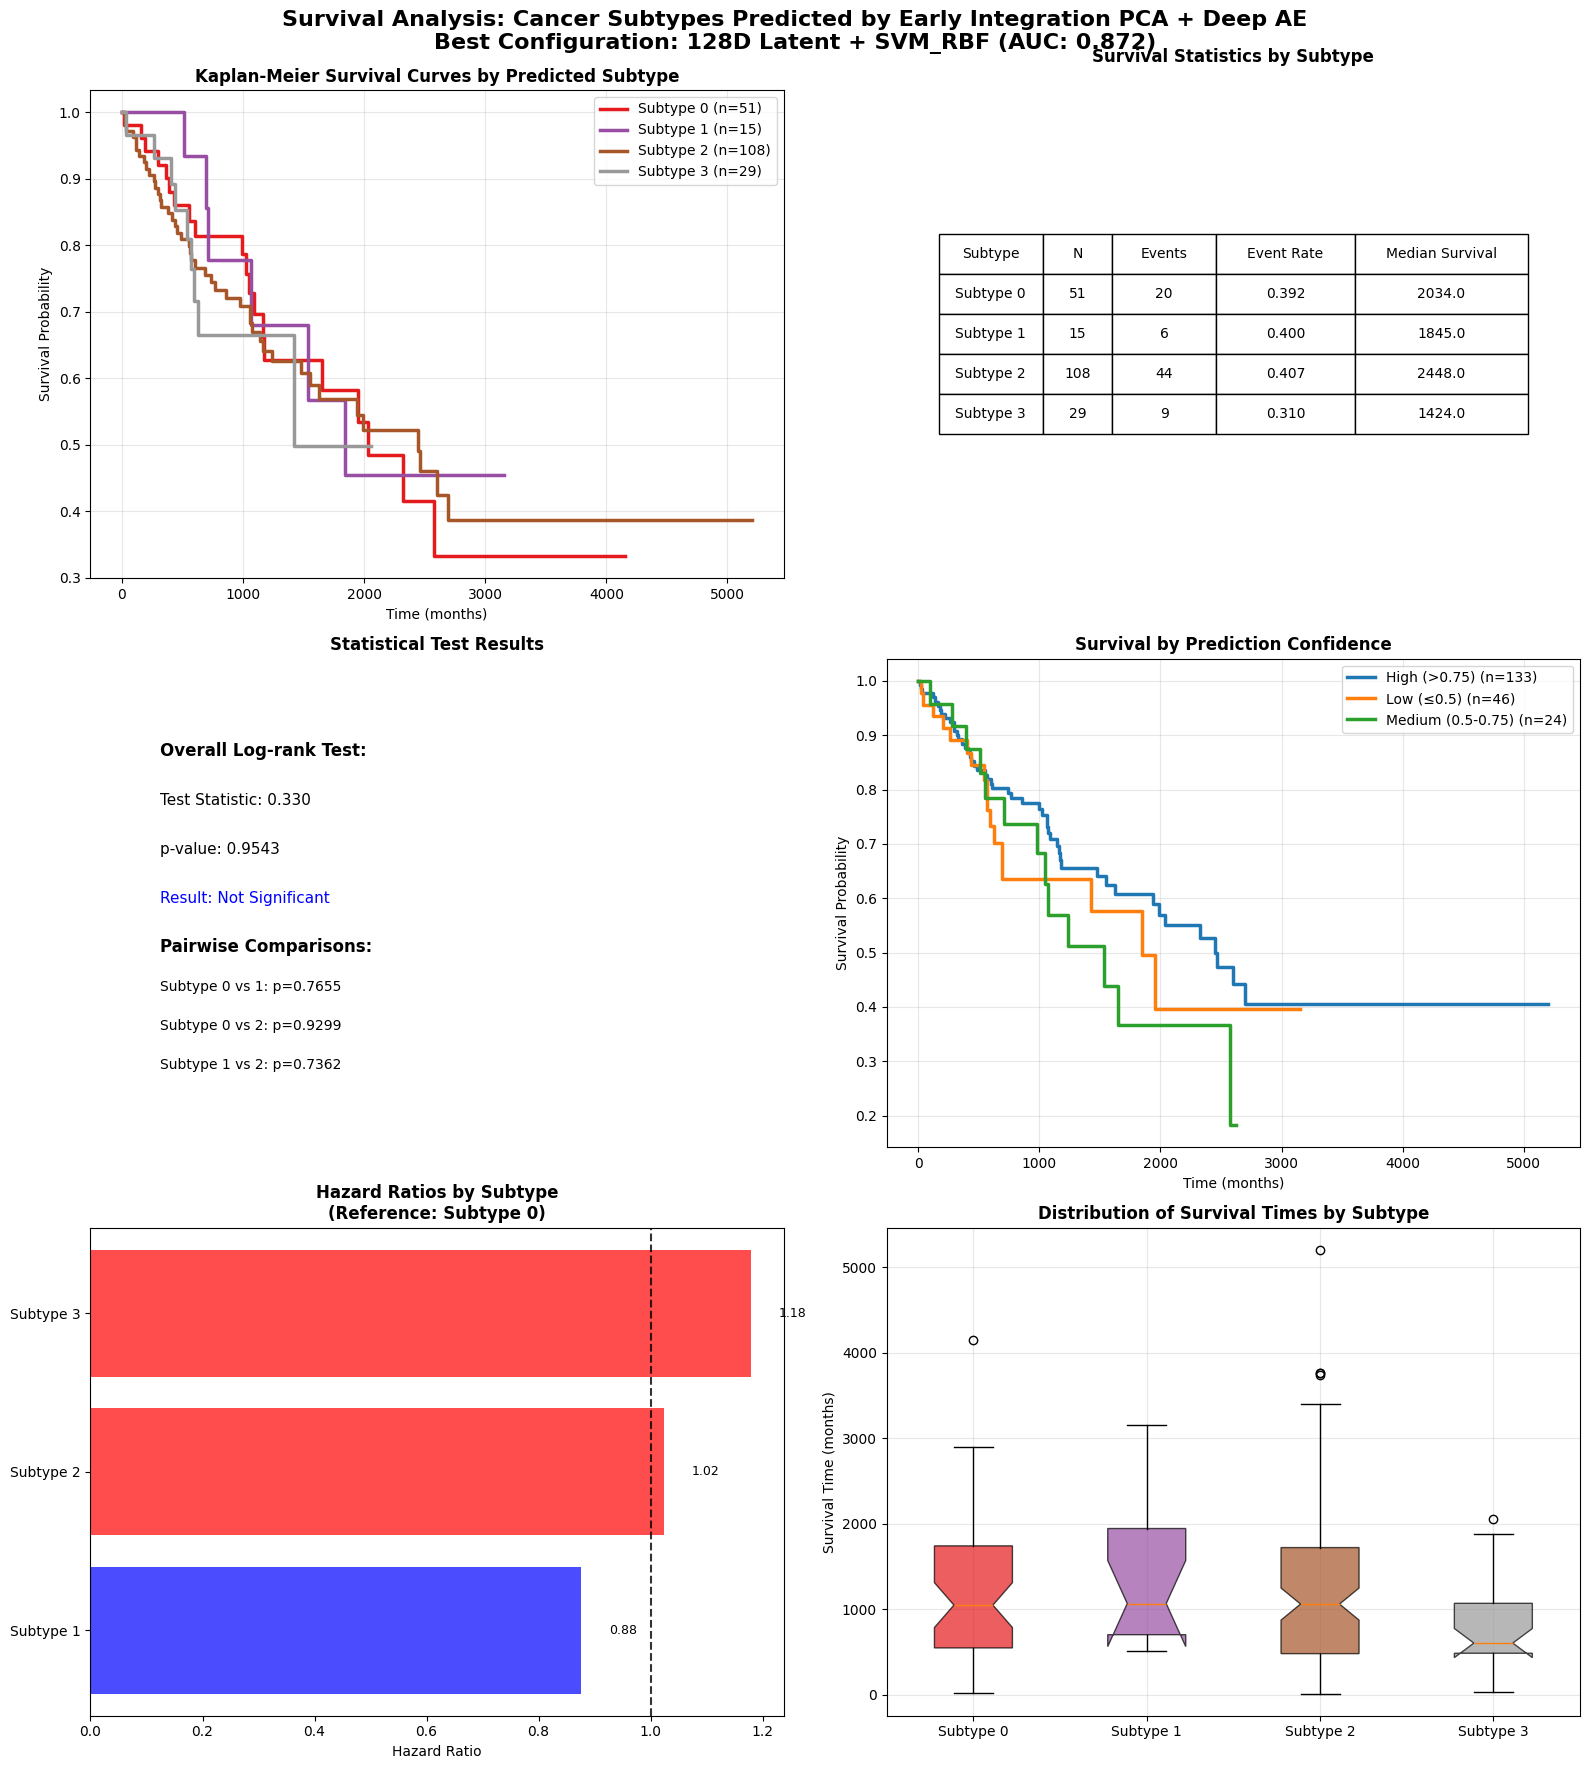


🏥 SURVIVAL ANALYSIS SUMMARY - EARLY INTEGRATION PCA + AUTOENCODER MODEL
🤖 Model Configuration: Deep AE (128D latent) + SVM_RBF
📊 Model Performance: AUC = 0.8716
👥 Total patients with survival data: 203
🔢 Number of predicted subtypes: 4
⚰️  Overall event rate (deaths): 0.389
📅 Median follow-up time: 995.0 months

📈 Subtype-specific survival statistics:
   Subtype 0: n=51, events=20, event_rate=0.392, median_survival=2034.0 months
   Subtype 1: n=15, events=6, event_rate=0.400, median_survival=1845.0 months
   Subtype 2: n=108, events=44, event_rate=0.407, median_survival=2448.0 months
   Subtype 3: n=29, events=9, event_rate=0.310, median_survival=1424.0 months


In [19]:
# Comprehensive Survival Analysis Visualization for Early Integration PCA + AE Model
if len(survival_analysis_df) > 0:
    print("🎨 Creating comprehensive survival analysis visualization...")
    print("=" * 60)
    
    # Create a comprehensive survival analysis visualization
    fig, axes = plt.subplots(3, 2, figsize=(16, 18))
    fig.suptitle(f'Survival Analysis: Cancer Subtypes Predicted by Early Integration PCA + {ae_type} AE\n' + 
                 f'Best Configuration: {best_overall_latent}D Latent + {best_overall_model} (AUC: {best_overall_auc:.3f})', 
                 fontsize=16, fontweight='bold')
    
    # Color palette for subtypes
    n_subtypes = len(survival_analysis_df['predicted_subtype'].unique())
    colors = plt.cm.Set1(np.linspace(0, 1, n_subtypes))
    subtype_colors = {subtype: colors[i] for i, subtype in enumerate(sorted(survival_analysis_df['predicted_subtype'].unique()))}
    
    # 1. Kaplan-Meier Survival Curves by Predicted Subtype
    kmf = KaplanMeierFitter()
    
    for subtype in sorted(survival_analysis_df['predicted_subtype'].unique()):
        subtype_data = survival_analysis_df[survival_analysis_df['predicted_subtype'] == subtype]
        kmf.fit(subtype_data['OS.time'], subtype_data['OS'], 
                label=f'Subtype {subtype} (n={len(subtype_data)})')
        kmf.plot_survival_function(ax=axes[0, 0], color=subtype_colors[subtype], 
                                 linewidth=2.5, ci_show=False)
    
    axes[0, 0].set_title('Kaplan-Meier Survival Curves by Predicted Subtype', fontweight='bold')
    axes[0, 0].set_xlabel('Time (months)')
    axes[0, 0].set_ylabel('Survival Probability')
    axes[0, 0].grid(True, alpha=0.3)
    axes[0, 0].legend(loc='best')
    
    # 2. Survival Statistics Summary
    axes[0, 1].axis('off')
    survival_stats = []
    
    for subtype in sorted(survival_analysis_df['predicted_subtype'].unique()):
        subtype_data = survival_analysis_df[survival_analysis_df['predicted_subtype'] == subtype]
        kmf.fit(subtype_data['OS.time'], subtype_data['OS'])
        
        median_survival = kmf.median_survival_time_
        event_rate = subtype_data['OS'].mean()
        n_patients = len(subtype_data)
        
        survival_stats.append({
            'Subtype': f'Subtype {subtype}',
            'N': n_patients,
            'Events': int(subtype_data['OS'].sum()),
            'Event Rate': f'{event_rate:.3f}',
            'Median Survival': f'{median_survival:.1f}' if not np.isnan(median_survival) else 'Not reached'
        })
    
    stats_df = pd.DataFrame(survival_stats)
    table = axes[0, 1].table(cellText=stats_df.values,
                            colLabels=stats_df.columns,
                            cellLoc='center',
                            loc='center',
                            colWidths=[0.15, 0.1, 0.15, 0.2, 0.25])
    table.auto_set_font_size(False)
    table.set_fontsize(10)
    table.scale(1, 2)
    axes[0, 1].set_title('Survival Statistics by Subtype', fontweight='bold', pad=20)
    
    # 3. Log-rank Test Results
    try:
        # Perform pairwise log-rank tests
        subtypes = sorted(survival_analysis_df['predicted_subtype'].unique())
        if len(subtypes) > 1:
            # Overall log-rank test
            results = multivariate_logrank_test(
                survival_analysis_df['OS.time'],
                survival_analysis_df['predicted_subtype'],
                survival_analysis_df['OS']
            )
            
            axes[1, 0].axis('off')
            axes[1, 0].text(0.1, 0.8, f'Overall Log-rank Test:', fontweight='bold', fontsize=12)
            axes[1, 0].text(0.1, 0.7, f'Test Statistic: {results.test_statistic:.3f}', fontsize=11)
            axes[1, 0].text(0.1, 0.6, f'p-value: {results.p_value:.4f}', fontsize=11)
            significance = "Significant" if results.p_value < 0.05 else "Not Significant"
            axes[1, 0].text(0.1, 0.5, f'Result: {significance}', fontsize=11, 
                           color='red' if results.p_value < 0.05 else 'blue')
            axes[1, 0].set_title('Statistical Test Results', fontweight='bold')
            
            # Pairwise comparisons for first few subtypes
            pairwise_results = []
            for i in range(min(3, len(subtypes))):
                for j in range(i+1, min(3, len(subtypes))):
                    subtype_i_data = survival_analysis_df[survival_analysis_df['predicted_subtype'] == subtypes[i]]
                    subtype_j_data = survival_analysis_df[survival_analysis_df['predicted_subtype'] == subtypes[j]]
                    
                    if len(subtype_i_data) > 5 and len(subtype_j_data) > 5:  # Minimum sample size
                        lr_result = logrank_test(
                            subtype_i_data['OS.time'], subtype_j_data['OS.time'],
                            subtype_i_data['OS'], subtype_j_data['OS']
                        )
                        pairwise_results.append({
                            'Comparison': f'Subtype {subtypes[i]} vs {subtypes[j]}',
                            'Test Statistic': f'{lr_result.test_statistic:.3f}',
                            'p-value': f'{lr_result.p_value:.4f}',
                            'Significant': 'Yes' if lr_result.p_value < 0.05 else 'No'
                        })
            
            if pairwise_results:
                y_pos = 0.4
                axes[1, 0].text(0.1, y_pos, 'Pairwise Comparisons:', fontweight='bold', fontsize=12)
                for idx, result in enumerate(pairwise_results):
                    y_pos -= 0.08
                    axes[1, 0].text(0.1, y_pos, f"{result['Comparison']}: p={result['p-value']}", fontsize=10)
    
    except Exception as e:
        axes[1, 0].text(0.1, 0.5, f'Statistical test error: {str(e)}', fontsize=10)
        axes[1, 0].set_title('Statistical Test Results', fontweight='bold')
    
    # 4. Survival by Prediction Confidence
    # Create confidence groups based on max probability
    survival_analysis_df['confidence_group'] = pd.cut(
        survival_analysis_df['max_prob'], 
        bins=[0, 0.5, 0.75, 1.0], 
        labels=['Low (≤0.5)', 'Medium (0.5-0.75)', 'High (>0.75)']
    )
    
    for conf_group in survival_analysis_df['confidence_group'].dropna().unique():
        group_data = survival_analysis_df[survival_analysis_df['confidence_group'] == conf_group]
        if len(group_data) > 2:
            kmf.fit(group_data['OS.time'], group_data['OS'], label=f'{conf_group} (n={len(group_data)})')
            kmf.plot_survival_function(ax=axes[1, 1], linewidth=2.5, ci_show=False)
    
    axes[1, 1].set_title('Survival by Prediction Confidence', fontweight='bold')
    axes[1, 1].set_xlabel('Time (months)')
    axes[1, 1].set_ylabel('Survival Probability')
    axes[1, 1].grid(True, alpha=0.3)
    axes[1, 1].legend(loc='best')
    
    # 5. Hazard Ratios (Cox Proportional Hazards Model)
    try:
        # Prepare data for Cox regression
        cox_data = survival_analysis_df[['OS.time', 'OS', 'predicted_subtype']].copy()
        
        # Create dummy variables for subtypes (reference: subtype 0)
        subtype_dummies = pd.get_dummies(cox_data['predicted_subtype'], prefix='subtype')
        cox_data = pd.concat([cox_data, subtype_dummies], axis=1)
        
        # Remove reference category and original subtype column
        reference_col = f'subtype_{sorted(survival_analysis_df["predicted_subtype"].unique())[0]}'
        if reference_col in cox_data.columns:
            cox_data = cox_data.drop([reference_col, 'predicted_subtype'], axis=1)
        
        # Fit Cox model
        cph = CoxPHFitter()
        cph.fit(cox_data, duration_col='OS.time', event_col='OS')
        
        # Plot hazard ratios
        hazard_ratios = cph.summary[['coef', 'exp(coef)', 'p']]
        hazard_ratios.columns = ['Log HR', 'Hazard Ratio', 'p-value']
        
        # Create hazard ratio plot
        hr_values = hazard_ratios['Hazard Ratio'].values
        hr_labels = [col.replace('subtype_', 'Subtype ') for col in hazard_ratios.index]
        
        bars = axes[2, 0].barh(range(len(hr_values)), hr_values, 
                              color=['red' if hr > 1 else 'blue' for hr in hr_values],
                              alpha=0.7)
        axes[2, 0].axvline(x=1, color='black', linestyle='--', alpha=0.8)
        axes[2, 0].set_yticks(range(len(hr_labels)))
        axes[2, 0].set_yticklabels(hr_labels)
        axes[2, 0].set_xlabel('Hazard Ratio')
        axes[2, 0].set_title('Hazard Ratios by Subtype\n(Reference: Subtype 0)', fontweight='bold')
        
        # Add HR values on bars
        for i, (bar, hr, p_val) in enumerate(zip(bars, hr_values, hazard_ratios['p-value'])):
            significance = '*' if p_val < 0.05 else ''
            axes[2, 0].text(hr + 0.05, bar.get_y() + bar.get_height()/2, 
                           f'{hr:.2f}{significance}', va='center', fontsize=9)
        
    except Exception as e:
        axes[2, 0].text(0.5, 0.5, f'Cox regression error: {str(e)}', 
                       ha='center', va='center', transform=axes[2, 0].transAxes)
        axes[2, 0].set_title('Hazard Ratios by Subtype', fontweight='bold')
    
    # 6. Survival Distribution by Subtype (Box Plot)
    survival_times_by_subtype = []
    subtype_labels = []
    
    for subtype in sorted(survival_analysis_df['predicted_subtype'].unique()):
        subtype_data = survival_analysis_df[survival_analysis_df['predicted_subtype'] == subtype]
        survival_times_by_subtype.append(subtype_data['OS.time'].values)
        subtype_labels.append(f'Subtype {subtype}')
    
    box_plot = axes[2, 1].boxplot(survival_times_by_subtype, labels=subtype_labels, 
                                 patch_artist=True, notch=True)
    
    # Color the boxes
    for patch, color in zip(box_plot['boxes'], [subtype_colors[s] for s in sorted(survival_analysis_df['predicted_subtype'].unique())]):
        patch.set_facecolor(color)
        patch.set_alpha(0.7)
    
    axes[2, 1].set_ylabel('Survival Time (months)')
    axes[2, 1].set_title('Distribution of Survival Times by Subtype', fontweight='bold')
    axes[2, 1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Print comprehensive summary statistics
    print("\n" + "="*80)
    print("🏥 SURVIVAL ANALYSIS SUMMARY - EARLY INTEGRATION PCA + AUTOENCODER MODEL")
    print("="*80)
    print(f"🤖 Model Configuration: {ae_type} AE ({best_overall_latent}D latent) + {best_overall_model}")
    print(f"📊 Model Performance: AUC = {best_overall_auc:.4f}")
    print(f"👥 Total patients with survival data: {len(survival_analysis_df)}")
    print(f"🔢 Number of predicted subtypes: {len(survival_analysis_df['predicted_subtype'].unique())}")
    print(f"⚰️  Overall event rate (deaths): {survival_analysis_df['OS'].mean():.3f}")
    print(f"📅 Median follow-up time: {survival_analysis_df['OS.time'].median():.1f} months")
    
    # Print subtype-specific statistics
    print(f"\n📈 Subtype-specific survival statistics:")
    for subtype in sorted(survival_analysis_df['predicted_subtype'].unique()):
        subtype_data = survival_analysis_df[survival_analysis_df['predicted_subtype'] == subtype]
        kmf.fit(subtype_data['OS.time'], subtype_data['OS'])
        median_surv = kmf.median_survival_time_
        event_rate = subtype_data['OS'].mean()
        print(f"   Subtype {subtype}: n={len(subtype_data)}, events={subtype_data['OS'].sum()}, " + 
              f"event_rate={event_rate:.3f}, median_survival={'Not reached' if np.isnan(median_surv) else f'{median_surv:.1f} months'}")
    
else:
    print("❌ Cannot perform survival analysis - no matching samples between survival and prediction data")